In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy.stats.mstats import winsorize
from random import seed
from random import random
import seaborn as sns

pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

## load data

In [2]:
def load_data(load):
    spot = pd.read_csv(f'spot_{load}_usdt_1h.csv', parse_dates=['timestamp'])
    perp = pd.read_csv(f'perp_{load}_usdt_1h.csv', parse_dates=['timestamp'])

    perp.sort_values(by = 'epoch', ascending=True, inplace=True)
    spot.sort_values(by = 'epoch', ascending=True, inplace=True)
    perp = perp.reset_index(drop=True)
    spot = spot.reset_index(drop=True)
    
    funding_rate = pd.read_csv(f'rate_{load}_usdt.csv', parse_dates=['timestamp'])
    
    return spot, perp, funding_rate
    

In [3]:
def brownian_motion(N, T, h):
    """
    Simulates a Brownian motion
    :param int N : the number of discrete steps
    :param int T: the number of continuous time steps
    :param float h: the variance of the increments
    """
    dt = 1.0 * T/N  # the normalizing constant; total number of steps
    random_increments = np.random.normal(0.0, 1.0 * h, N)*np.sqrt(dt)  # the epsilon values
    brownian_motion = np.cumsum(random_increments)  # calculate the brownian motion
    brownian_motion = np.insert(brownian_motion, 0, 0.0) # insert the initial condition

    return brownian_motion, random_increments

def drifted_brownian_motion(mu, sigma, N, T):
    """Simulates a Brownian Motion with drift.
    
    :param float mu: drift coefficient
    :param float sigma: volatility coefficient
    :param int N : number of discrete steps
    :param int T: number of continuous time steps
    :param int seed: initial seed of the random generator
    :returns list: drifted Brownian motion
    """
    # standard brownian motion
    W, _ = brownian_motion(N, T , 1.0)
    # the normalizing constant
    dt = 1.0 * T/N
    # generate the time steps
    time_steps = np.linspace(0.0, N*dt, N+1)
    # calculate the Brownian Motion with drift
    X = mu * time_steps + sigma * W
    return X

In [4]:
def create_panel(spot, perp, funding_rate):
    
    #create the panel
    panel = perp[['epoch', 'timestamp', 'close', 'usd_volume']]
    panel['day'] = panel['timestamp'].dt.round('D')
    panel = panel.rename(columns={'close': 'perp', 'usd_volume': 'perp_usd_volume'})

    panel = pd.merge(panel,
                     spot[['epoch', 'close', 'usd_volume']],
                     on='epoch', 
                     how='left')
    panel = panel.rename(columns={'close': 'spot', 'usd_volume': 'spot_usd_volume'})
    
    panel = pd.merge(panel,
                     funding_rate[['epoch', 'funding_rate']],
                     on='epoch', 
                     how='left')

    panel = pd.merge(panel,
                     i_crypto[['epoch', 'apy']],
                     on='epoch', 
                     how='right')
    panel = panel.rename(columns={'apy': 'icrypto'})

    panel = pd.merge(panel,
                     i_usdt[['epoch', 'apy']],
                     on='epoch', 
                     how='right')
    panel = panel.rename(columns={'apy': 'iusdt'})

    panel.sort_values(by = 'epoch', ascending=True, inplace=True)
    panel = panel.reset_index(drop=True)

    return panel

In [5]:
currencies = ['eth', 'btc', 'doge', 'bnb', 'ada']
panel_all = []

#currently we are simulating the interest
spot, perp, funding_rate = load_data(currencies[0])
np.random.seed(40)
i_usdt = perp.copy()
i_usdt = i_usdt[['epoch', 'timestamp']]
mu = 0.05
sigma = 0.01
#i_usdt['apy'] = np.random.normal(mu, sigma, len(i_usdt))
X = drifted_brownian_motion(-0.03, sigma, len(i_usdt)-1, 1)
i_usdt['apy'] = X+mu

for i in range (0,len(currencies)):
    spot, perp, funding_rate = load_data(currencies[i])
    
    #currently we are simulating the interest
    i_crypto = perp.copy()
    i_crypto = i_crypto[['epoch', 'timestamp']]
    mu = 0.01
    sigma = 0.005
    X = drifted_brownian_motion(-0.005, sigma, len(i_crypto)-1, 1)
    i_crypto['apy'] = X+mu
    
    panel_temp = create_panel(spot, perp, funding_rate)
    panel_all.append(panel_temp)
    print(f'{currencies[i]} loaded')

eth loaded
btc loaded
doge loaded
bnb loaded
ada loaded


## cleaning

In [6]:
cutoff = '2022-06-01 12:00:00'

eth_start = '2019-11-27 07:00:00'
btc_start = '2019-09-10 08:00:00'
doge_start = '2020-07-10 09:00:00'
bnb_start = '2020-02-10 08:00:00'
ada_start = '2020-01-31 08:00:00'

for i in range (0,len(currencies)):
    panel_all[i] = panel_all[i][panel_all[i]['timestamp'] <= cutoff] #cutoff, such that all data is equally long

In [7]:
#check for dataset and na values
for i in range (0,len(currencies)):
    panel_all[i].info()
    #panel_all[i][panel_all[i]['spot'].isnull()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22014 entries, 0 to 22013
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   epoch            22014 non-null  int64         
 1   timestamp        22014 non-null  datetime64[ns]
 2   perp             22014 non-null  float64       
 3   perp_usd_volume  22014 non-null  float64       
 4   day              22014 non-null  datetime64[ns]
 5   spot             21984 non-null  float64       
 6   spot_usd_volume  21984 non-null  float64       
 7   funding_rate     2752 non-null   float64       
 8   icrypto          22014 non-null  float64       
 9   iusdt            22014 non-null  float64       
dtypes: datetime64[ns](2), float64(7), int64(1)
memory usage: 1.8 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22014 entries, 0 to 22013
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --

In [8]:
#fill or drop na
for i in range (0,len(currencies)):

    panel_all[i]['spot'] = panel_all[i]['spot'].fillna(method='ffill')
    panel_all[i]['spot_usd_volume'] = panel_all[i]['spot_usd_volume'].fillna(method='ffill')
    panel_all[i]['funding_rate'] = panel_all[i]['funding_rate'].fillna(0)
    #panel_all[i] = panel_all[i].dropna()
    panel_all[i].sort_values(by = 'epoch', ascending=True, inplace=True)
    panel_all[i] = panel_all[i].reset_index(drop=True)

## data calculation

In [9]:
for i in range (0,len(currencies)):
    T = 1/(3*365) #we receive interest every 8h for 365 days

    # cip = yt - pt
    panel_all[i]['yt'] = panel_all[i]['iusdt'] - panel_all[i]['icrypto']
    panel_all[i]['pt'] = -(1/T)*(np.log(panel_all[i]['perp']) - np.log(panel_all[i]['spot'])) 


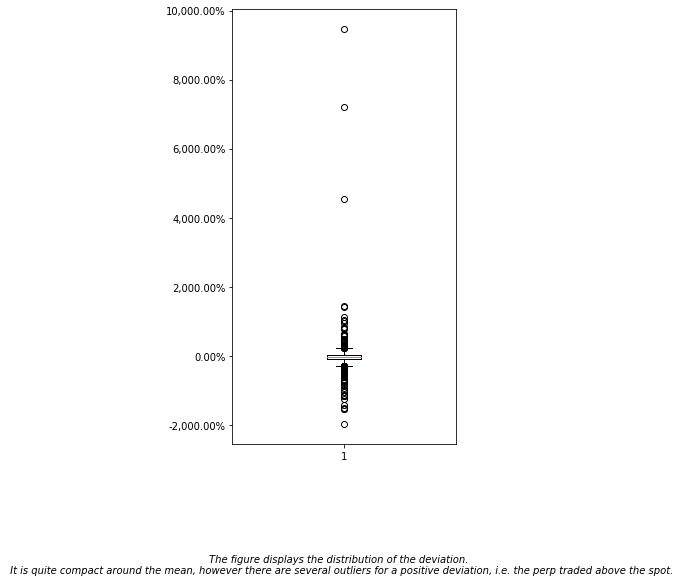

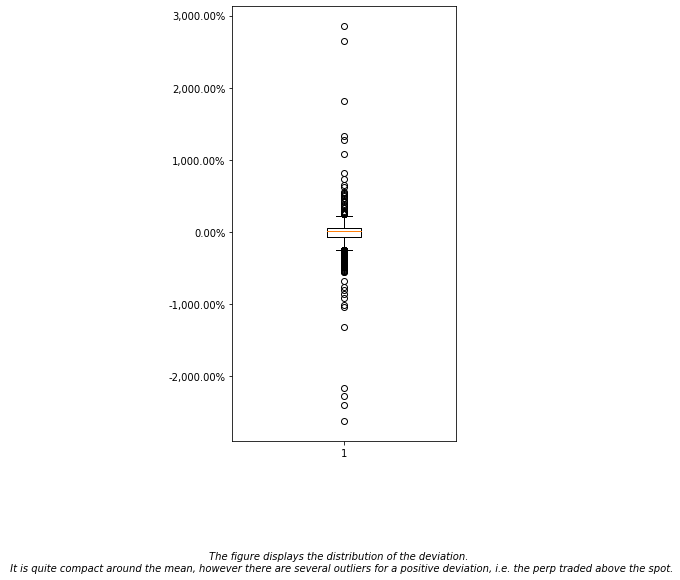

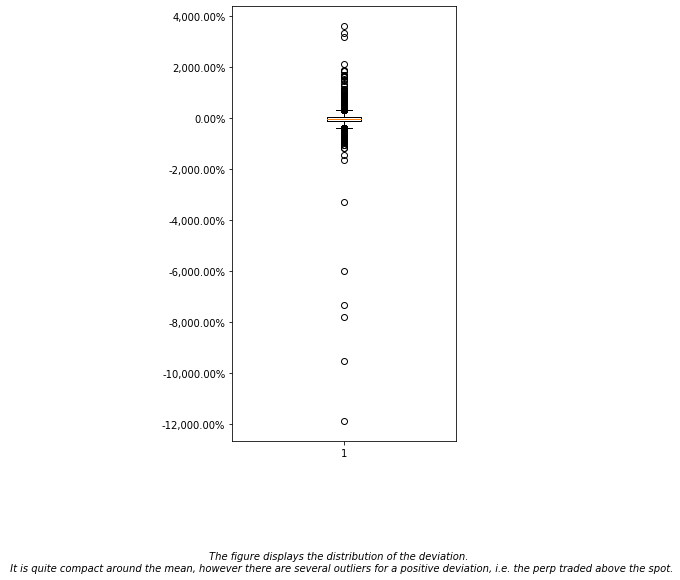

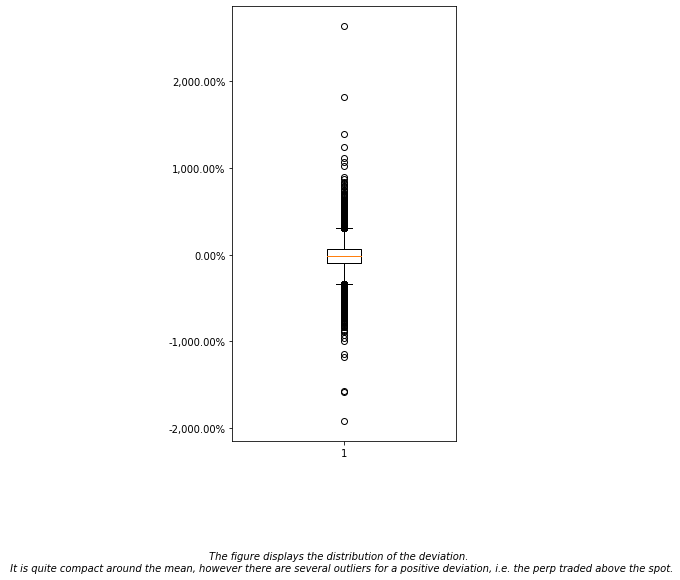

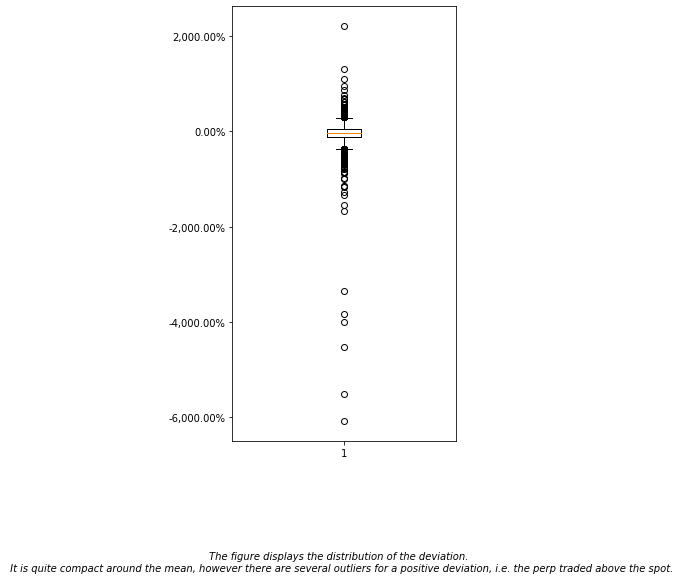

In [10]:
for i in range (0,len(currencies)):
    #take a look at the distribution before winsorization
    
    fig, ax = plt.subplots(figsize =(4,8))
    ax.boxplot(panel_all[i]['pt'])
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    txt = f'The figure displays the distribution of the deviation. \n It is quite compact around the mean, however there are several outliers for a positive deviation, i.e. the perp traded above the spot.'
    fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

    plt.show()

In [11]:
#we winsorize at +- 2 standard deviations, to address extrem outliers
for i in range (0,len(currencies)):
    panel_all[i]['yt'] = winsorize(panel_all[i]['yt'], limits=(0.025, 0.025))
    panel_all[i]['pt'] = winsorize(panel_all[i]['pt'], limits=(0.025, 0.025))

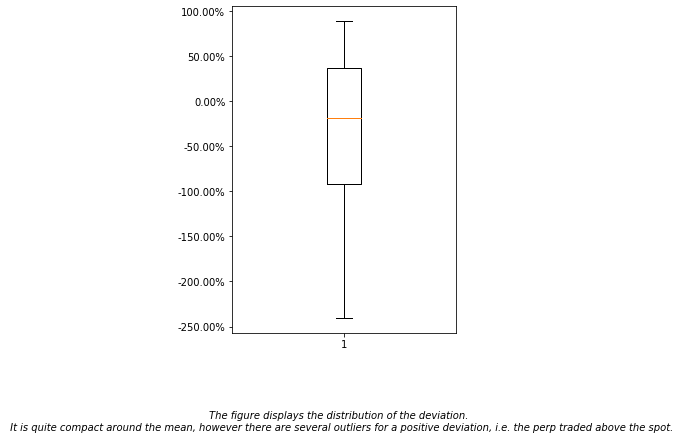

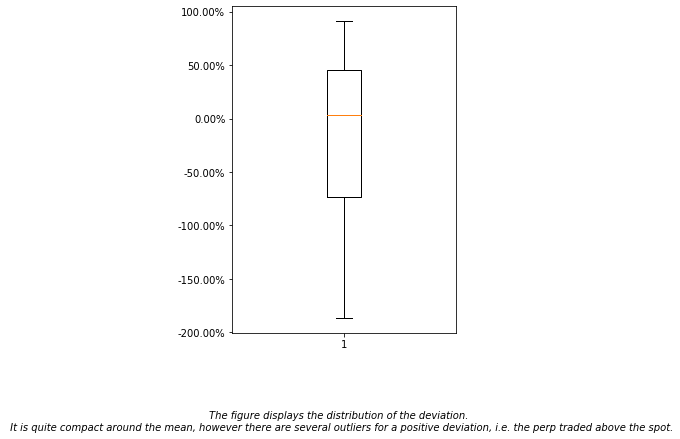

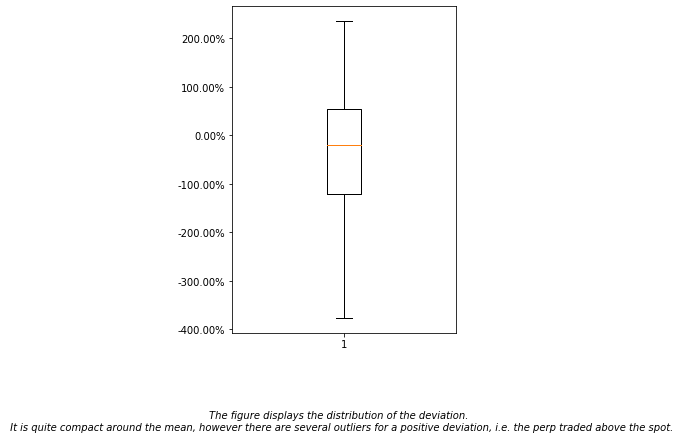

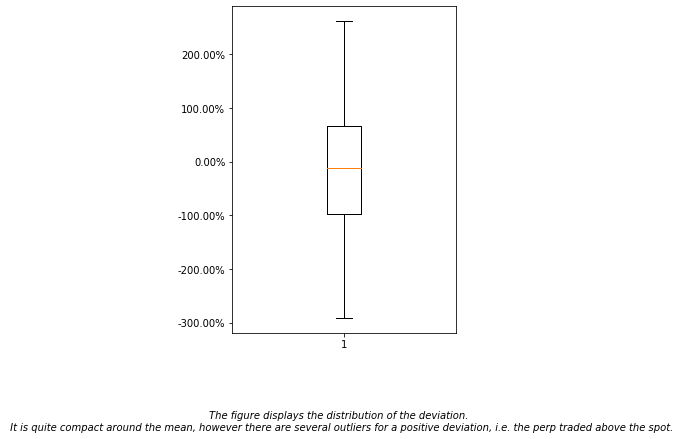

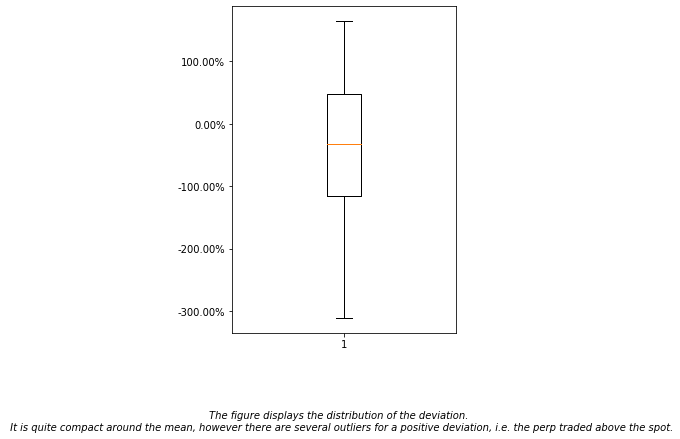

In [12]:
for i in range (0,len(currencies)):
    #take a look at the distribution after winsorization
    
    fig, ax = plt.subplots(figsize =(4,6))
    ax.boxplot(panel_all[i]['pt'])
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    txt = f'The figure displays the distribution of the deviation. \n It is quite compact around the mean, however there are several outliers for a positive deviation, i.e. the perp traded above the spot.'
    fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

    plt.show()

In [13]:
for i in range (0,len(currencies)):
    panel_all[i]['cip'] = panel_all[i]['yt'] + panel_all[i]['pt']
    
    #taking the absolute mean
    mean = np.round(panel_all[i]['cip'].mean(),4)

    days = (panel_all[i]['day'].iloc[-1] - panel_all[i]['day'].iloc[0]).days

    print(f'{currencies[i]}: The mean deviation from the covered interest rate parity is {mean*100}%. Sampled from Binance over {days} days.')

eth: The mean deviation from the covered interest rate parity is -30.17%. Sampled from Binance over 917 days.
btc: The mean deviation from the covered interest rate parity is -13.74%. Sampled from Binance over 917 days.
doge: The mean deviation from the covered interest rate parity is -35.91%. Sampled from Binance over 691 days.
bnb: The mean deviation from the covered interest rate parity is -12.73%. Sampled from Binance over 842 days.
ada: The mean deviation from the covered interest rate parity is -37.15%. Sampled from Binance over 852 days.


## calculate statistics

In [14]:
#we calculate the statistics mean, std for each year
cip_all = []
cip_all_std = []
cip_all_std_ann = []
yt_all = []
yt_all_std = []
pt_all = []
pt_all_std = []
spot_volume = []
perp_volume = []

for i in range(0, len(currencies)):
    cip_temp = []
    cip_temp_std = []
    cip_temp_std_ann = []
    yt_temp = []
    yt_temp_std = []
    pt_temp = []
    pt_temp_std = []
    spot_volume_temp = []
    perp_volume_temp = []
    
    if panel_all[i]['timestamp'].dt.year.iloc[0] != 2019: #if timeseries starts after 2019
        cip_temp.append(0)
        cip_temp_std.append(0)
        cip_temp_std_ann.append(0)
        yt_temp.append(0)
        yt_temp_std.append(0)
        pt_temp.append(0)
        pt_temp_std.append(0)
        spot_volume_temp.append(0)
        perp_volume_temp.append(0)

    
    for j in range(panel_all[i]['timestamp'].dt.year.iloc[0], panel_all[i]['timestamp'].dt.year.iloc[-1]+1):     
        
        cip_temp.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['cip'].mean())

        cip_temp_std.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['cip'].std())
        
        cip_temp_std_ann.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['cip'].std()*np.sqrt(len(panel_all[i][panel_all[i]['timestamp'].dt.year == j])))
        
        yt_temp.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['yt'].mean())

        yt_temp_std.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['yt'].std())
        
        pt_temp.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['pt'].mean())

        pt_temp_std.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['pt'].std())
        
        spot_volume_temp.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['spot_usd_volume'].sum())
        perp_volume_temp.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['perp_usd_volume'].sum())


    cip_temp.append(panel_all[i]['cip'].mean())
    cip_all.append(cip_temp)
    
    cip_temp_std.append(panel_all[i]['cip'].std())
    cip_all_std.append(cip_temp_std)
    
    cip_temp_std_ann.append(panel_all[i]['cip'].std()*np.sqrt(len(panel_all[i]['timestamp'])))
    cip_all_std_ann.append(cip_temp_std_ann)
    
    yt_temp.append(panel_all[i]['yt'].mean())
    yt_all.append(yt_temp)
    
    yt_temp_std.append(panel_all[i]['yt'].std())
    yt_all_std.append(yt_temp_std)
        
    pt_temp.append(panel_all[i]['pt'].mean())
    pt_all.append(pt_temp)
    
    pt_temp_std.append(panel_all[i]['pt'].std())
    pt_all_std.append(pt_temp_std)
    
    spot_volume_temp.append(panel_all[i]['spot_usd_volume'].sum())
    spot_volume.append(spot_volume_temp)
    
    perp_volume_temp.append(panel_all[i]['perp_usd_volume'].sum())
    perp_volume.append(perp_volume_temp)

        

    



## results table

In [15]:
#unlisting list for dataframe of results
cip_all = [np.round(item,4) for sublist in cip_all for item in sublist]
cip_all_std = [np.round(item,4) for sublist in cip_all_std for item in sublist]
cip_all_std_ann = [np.round(item,4) for sublist in cip_all_std_ann for item in sublist]
yt_all = [np.round(item,4)  for sublist in yt_all for item in sublist]
yt_all_std = [np.round(item,4) for sublist in yt_all_std for item in sublist]
pt_all = [np.round(item,4)  for sublist in pt_all for item in sublist]
pt_all_std = [np.round(item,4) for sublist in pt_all_std for item in sublist]

spot_volume = [np.round(item/1e9,2) for sublist in spot_volume for item in sublist]
perp_volume = [np.round(item/1e9,2) for sublist in perp_volume for item in sublist]

In [16]:
iterables = [currencies, ['2019', '2020', '2021', '2022', 'mean']]

index = pd.MultiIndex.from_product(iterables)

results = pd.DataFrame(
    {'cip': cip_all,
    '': cip_all_std,
    'yt': yt_all,
    ' ': yt_all_std, 
    'pt': pt_all,
    '  ': pt_all_std,
    'volume_spot_$_bn': spot_volume,
    'volume_future_$_bn': perp_volume,
    'volume_future/spot': np.round([i/j for i,j in zip(perp_volume, spot_volume)],1)
    },index = index)

results = results.dropna(axis=0) #drop years without data
print('The table shows the theoretical deviation from the covered interest parity for three markets ETHUSD, BTCUSD, DOGEUSD. The cip deviation was 50.14% for ETHUSD in 2019 with a 30.61% standard deviation. It is a combination of the 3.98% interest rate differential - denoted as yt. And 46.62% deviation between spot and future - denoted as pt. The last column states the yearly trading volume in USD billion and the dominance of future trading over spot.')
results

The table shows the theoretical deviation from the covered interest parity for three markets ETHUSD, BTCUSD, DOGEUSD. The cip deviation was 50.14% for ETHUSD in 2019 with a 30.61% standard deviation. It is a combination of the 3.98% interest rate differential - denoted as yt. And 46.62% deviation between spot and future - denoted as pt. The last column states the yearly trading volume in USD billion and the dominance of future trading over spot.


cip              yt              pt          volume_spot_$_bn  \
eth  2019  0.4750  0.3071  0.0404  0.0007  0.4346  0.3071              1.39   
     2020 -0.4488  0.7725  0.0384  0.0053 -0.4872  0.7727            101.70   
     2021 -0.5551  0.8434  0.0187  0.0064 -0.5739  0.8463            772.73   
     2022  0.4863  0.2272  0.0102  0.0012  0.4761  0.2272            215.68   
     mean -0.3017  0.8324  0.0260  0.0126 -0.3276  0.8356           1091.50   
btc  2019  0.5625  0.2736  0.0396  0.0007  0.5228  0.2737             11.30   
     2020 -0.1257  0.7049  0.0346  0.0047 -0.1604  0.7050            286.61   
     2021 -0.4544  0.7498  0.0174  0.0069 -0.4718  0.7528           1155.24   
     2022  0.4379  0.2272  0.0083  0.0007  0.4295  0.2272            293.04   
     mean -0.1374  0.7393  0.0236  0.0118 -0.1610  0.7409           1746.19   
doge 2020 -0.3852  1.5524  0.0322  0.0015 -0.4175  1.5522              0.68   
     2021 -0.7021  1.3002  0.0171  0.0080 -0.7193  1.3020            336.59   
     2022  0.4970  0.6249  0.0041  0.0011  0.4930  0.6250             24.66   
     mean -0.3591  1.3454  0.0181  0.0113 -0.3772  1.3482            361.93   
bnb  2020 -0.2789  1.3142  0.0387  0.0026 -0.3176  1.3140             21.33   
     2021 -0.3128  1.1832  0.0220  0.0063 -0.3348  1.1857            333.12   
     2022  0.6451  0.5351  0.0125  0.0009  0.6326  0.5351             47.88   
     mean -0.1273  1.2071  0.0267  0.0110 -0.1541  1.2101            402.33   
ada  2020 -0.5500  1.1214  0.0341  0.0037 -0.5841  1.1211             13.21   
     2021 -0.6060  1.0902  0.0180  0.0071 -0.6240  1.0926            215.81   
     2022  0.5891  0.6180  0.0079  0.0008  0.5812  0.6181             25.94   
     mean -0.3715  1.1280  0.0225  0.0113 -0.3940  1.1315            254.96   

           volume_future_$_bn  volume_future/spot  
eth  2019                2.03                 1.5  
     2020              264.44                 2.6  
     2021             2772.51                 3.6  
     2022              846.24                 3.9  
     mean             3885.22                 3.6  
btc  2019               35.11                 3.1  
     2020             1139.74                 4.0  
     2021             6402.78                 5.5  
     2022             2127.78                 7.3  
     mean             9705.41                 5.6  
doge 2020                1.42                 2.1  
     2021              529.88                 1.6  
     2022               81.61                 3.3  
     mean              612.91                 1.7  
bnb  2020               18.38                 0.9  
     2021              529.92                 1.6  
     2022               73.41                 1.5  
     mean              621.70                 1.5  
ada  2020               20.19                 1.5  
     2021              405.54                 1.9  
     2022               98.94                 3.8  
     mean              524.68                 2.1

## pretty result table

In [ ]:
#finetuning for presentation

cip_all = ['' if item == 0 else item for item in cip_all]
cip_all_std = ['' if item == 0 else item for item in cip_all_std]
cip_all_std_ann = ['' if item == 0 else item for item in cip_all_std_ann]
yt_all_std = ['' if item == 0 else item for item in yt_all_std]
pt_all_std = ['' if item == 0 else item for item in pt_all_std]

cip_all_std_pretty = ['' if item == '' else '(' + str(item)+ ')' for item in cip_all_std]
cip_all_std_ann_pretty = ['' if item == '' else '(' + str(item)+ ')' for item in cip_all_std_ann]
yt_all_std_pretty = ['' if item == '' else '(' + str(item)+ ')' for item in yt_all_std]
pt_all_std_pretty = ['' if item == '' else '(' + str(item)+ ')' for item in pt_all_std]

In [ ]:
#table as in Du 2018

iterables = [currencies, ['mean', 'std']]

index = pd.MultiIndex.from_product(iterables)

results_pretty = pd.DataFrame(
    {'2019': [item for sublist in list(zip(cip_all[0::5], cip_all_std_pretty[0::5])) for item in sublist],
    '2020': [item for sublist in list(zip(cip_all[1::5], cip_all_std_pretty[1::5])) for item in sublist],
    '2021': [item for sublist in list(zip(cip_all[2::5], cip_all_std_pretty[2::5])) for item in sublist],
    '2022': [item for sublist in list(zip(cip_all[3::5], cip_all_std_pretty[3::5])) for item in sublist],
    'all': [item for sublist in list(zip(cip_all[4::5], cip_all_std_pretty[4::5])) for item in sublist]},index = index)

results_pretty = results_pretty.dropna(axis=0) #drop years without data
results_pretty

## various theory plots

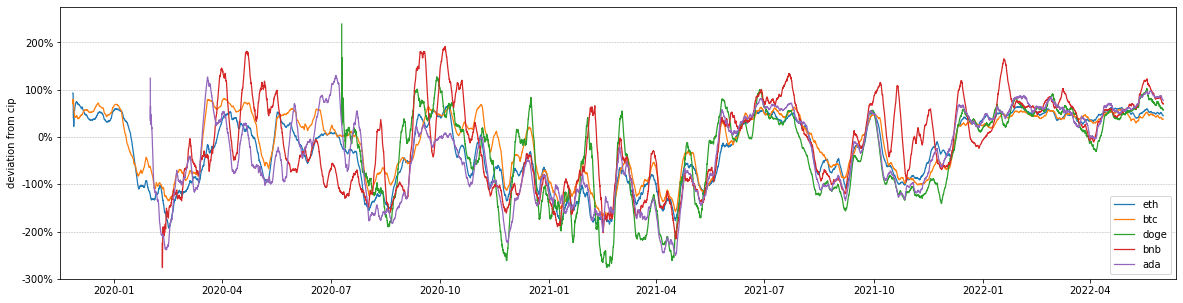

In [17]:
#plotting the cip over time
sns.color_palette()

panel_all[i].sort_values(by = 'epoch', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize =(20,5))

for i in range (0,len(currencies)):
    ax.plot(panel_all[i]['timestamp'], panel_all[i]['cip'].rolling(24*7, min_periods=1).mean(), linewidth=1.25)

ax.set_ylim(-3, 2.75)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


left, right = plt.xlim()
ax.set_xlim(left+35, right-35)

ax.legend(['eth', 'btc', 'doge', 'bnb', 'ada'], loc='lower right')
ax.set_ylabel('deviation from cip')
ax.grid(axis='y', linestyle='--', linewidth=.5)

plt.savefig('figure_1.png')

plt.show()

-4.0 3.0


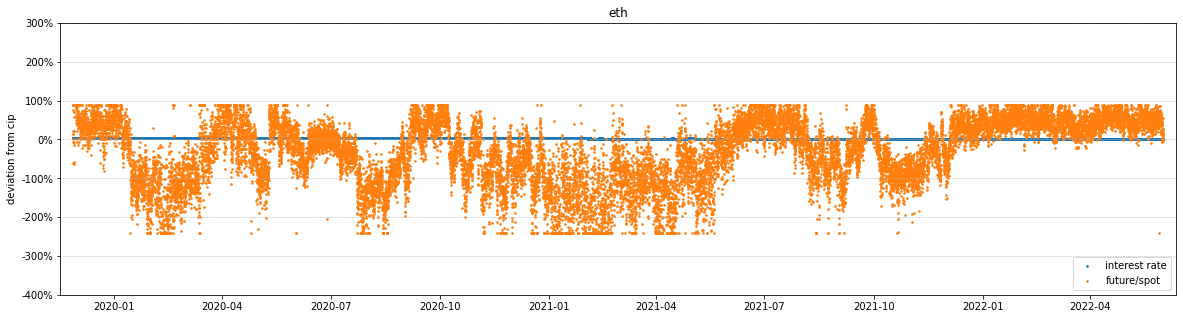

-4.0 3.0


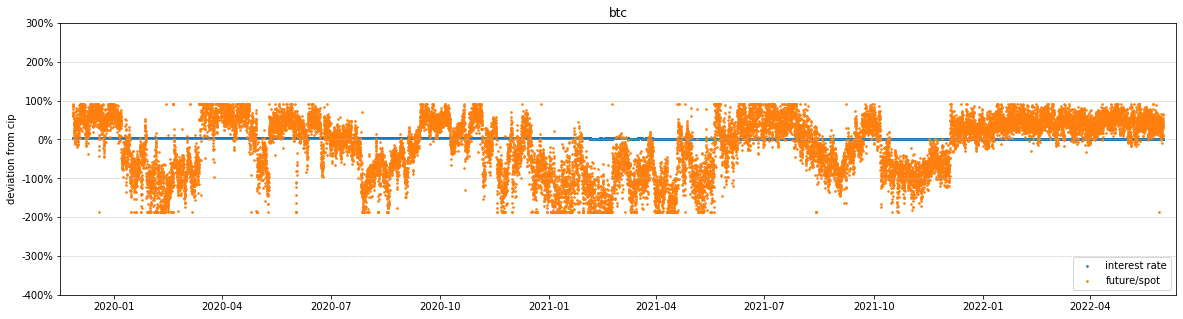

-4.0 3.0


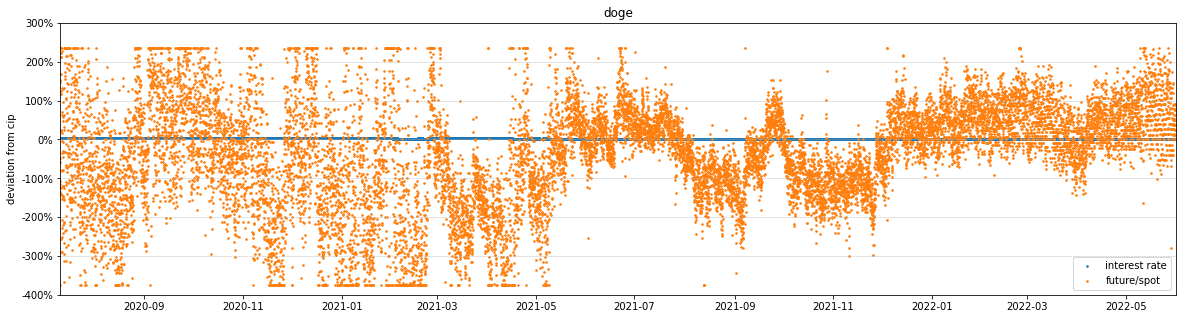

-4.0 3.0


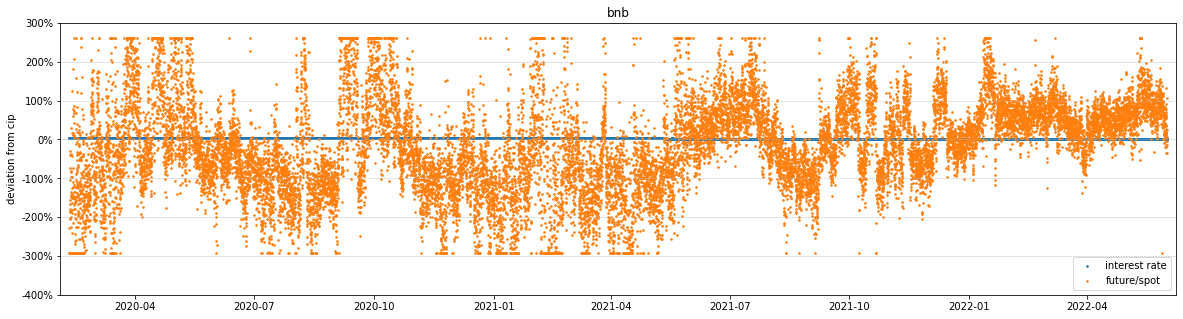

-4.0 3.0


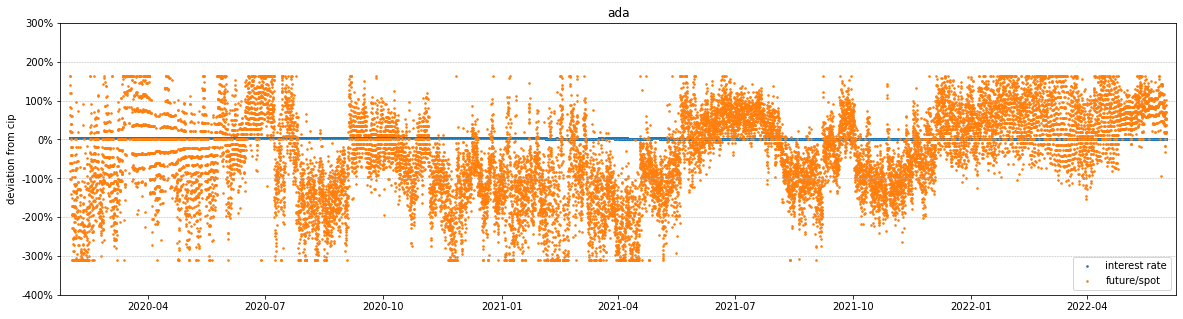

In [18]:
for i in range (0,len(currencies)):
    #plotting the cip over time
    sns.color_palette()
    panel_all[i].sort_values(by = 'epoch', ascending=True, inplace=True)

    fig, ax = plt.subplots(figsize =(20,5))

    ax.scatter(panel_all[i]['timestamp'].iloc[0:], panel_all[i]['yt'].iloc[0:], s=2.5)
    ax.scatter(panel_all[i]['timestamp'].iloc[0:], panel_all[i]['pt'].iloc[0:], s=2.5)
    
    ax.set_ylim(-4, 3)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    
    left, right = plt.xlim()
    ax.set_xlim(left+35, right-35)

    ax.legend(['interest rate', 'future/spot'], loc='lower right')
    ax.set_ylabel('deviation from cip')
    
    ax.grid(axis='y', linestyle='--', linewidth=.5)

    plt.title(f'{currencies[i]}')
    
    plt.savefig(f'deviation_{i}.png')
    plt.show()

In [42]:
df_corr = panel_all[0][['epoch', 'cip', 'spot']]
df_corr = df_corr.rename(columns={'cip': 'cip_eth', 'spot': 'spot_eth'})

df_corr = pd.merge(df_corr,
                     panel_all[1][['epoch', 'cip', 'spot']],
                     on='epoch', 
                     how='left')
df_corr = df_corr.rename(columns={'cip': 'cip_btc', 'spot': 'spot_btc'})

df_corr = pd.merge(df_corr,
                     panel_all[2][['epoch', 'cip', 'spot']],
                     on='epoch', 
                     how='left')
df_corr = df_corr.rename(columns={'cip': 'cip_doge', 'spot': 'spot_doge'})

df_corr = pd.merge(df_corr,
                     panel_all[3][['epoch', 'cip', 'spot']],
                     on='epoch', 
                     how='left')
df_corr = df_corr.rename(columns={'cip': 'cip_bnb', 'spot': 'spot_bnb'})

df_corr = pd.merge(df_corr,
                     panel_all[4][['epoch', 'cip', 'spot']],
                     on='epoch', 
                     how='left')
df_corr = df_corr.rename(columns={'cip': 'cip_ada', 'spot': 'spot_ada'})
   

df_corr = df_corr.drop(['epoch'], axis=1)

In [43]:
df_corr = df_corr[['cip_eth', 'cip_btc', 'cip_doge', 'cip_bnb', 'cip_ada', 'spot_eth', 'spot_btc', 'spot_doge', 'spot_bnb', 'spot_ada']]

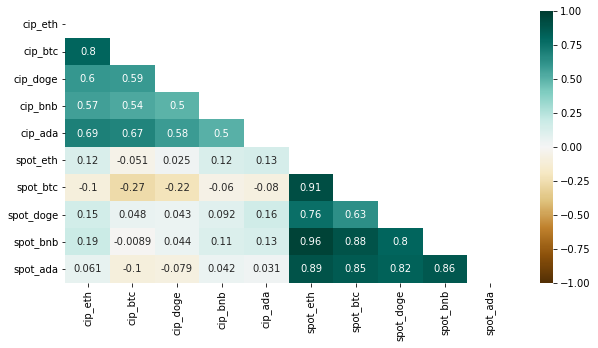

In [46]:
plt.figure(figsize=(10, 5))

mask = np.triu(np.ones_like(df_corr.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.savefig(f'figure_6.png')

plt.show()

In [ ]:
#take a look at the funding rate over time
i = 0

fig, ax = plt.subplots(figsize =(20,4))

ax.plot(panel_all[i]['timestamp'].iloc[0::24], panel_all[i]['cip'].iloc[0::24], linewidth=1)
secax = ax.twinx()
secax.plot(panel_all[i]['timestamp'].iloc[0::12], panel_all[i]['spot'].iloc[0::12], color='grey', linewidth=1)
secax.set_yscale('log')
secax.set_yticks([])

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

ax.set_ylabel('8h funding rate')

r = np.corrcoef(panel_all[0]['cip'], panel_all[0]['spot'])

txt = 'The figure displays the 8h funding rate of the ETH/USDT perpetual swap on Binance from 11/2019 to 03/2022. The orange line denotes the log of the price over time. \n The funding rate tends to decline over time.'
fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize =(15,4))
col = ['b', 'r']


for i in range(0,2):
    temp = []
    for j in range(1,10): 
        temp.append(abs(panel_all[i]['cip'].iloc[j::8].mean()))
    
    plt.plot(temp, c=col[i], label=currencies[i])

ax.legend(loc='lower right')
ax.set_ylabel('cip violation')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.xticks(np.arange(9), labels = ['T', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1', 'T'])

txt = f'The figure displays the mean cip violation during an 8h time interval. Every 8h the funding rate is paid to foster the alignment between future and spot. The funding rate payments are denoted as T on the x-axis. \n The divergence is the largest on the funding rate payment, afterwards future and spot converge steadily, until the spread widens again at the funding rate payment.'
fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

plt.show()



In [ ]:
fig, ax = plt.subplots(figsize =(10,6))

ax.scatter(panel_all[0]['cip'][1::8], panel_all[0]['funding_rate'][1::8], s=2.5)
ax.scatter(panel_all[0][(panel_all[0]['cip'] > 0) & (panel_all[0]['funding_rate'] > 0)]['cip'], panel_all[0][(panel_all[0]['cip'] > 0) & (panel_all[0]['funding_rate'] > 0)]['funding_rate'], s=2.5, color='r')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax.set_ylabel('funding_rate')

vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_xlabel('cip')

ax.grid(axis='y', linestyle='--', linewidth=.5)

plt.show()